# Autoregressive softmax regression

Try softmax regression from DBDA2

In [1]:
import pymc3 as pm
print(pm.__version__)

import theano.tensor as tt
import theano
print(theano.__version__)

import patsy
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

3.5
1.0.2


In [2]:
SEED = 20180727

In [3]:
df = pd.read_csv(r'..\datasets\SoftmaxRegData1.csv', dtype={'Y':'category'})
df.head()

,X1,X2,Y
0,-0.087147,-1.081342,2
1,-0.722566,-1.583863,1
2,0.179190,0.971790,3
3,-1.159752,0.502624,3
4,-0.727118,1.375704,3


In [37]:
_, X = patsy.dmatrices('Y ~ 1 + standardize(X1) + standardize(X2)', data=df)
X

DesignMatrix with shape (475, 3)
  Intercept  standardize(X1)  standardize(X2)
          1         -0.08724         -1.08248
          1         -0.72333         -1.58553
          1          0.17938          0.97282
          1         -1.16097          0.50315
          1         -0.72788          1.37715
          1          0.53398          1.77652
          1         -0.18953         -0.53784
          1          0.48690          1.22491
          1          0.36394         -1.29935
          1          0.07076         -0.23265
          1         -1.58310          1.55422
          1          0.04860         -1.52408
          1          0.87570         -1.16321
          1          0.57818          0.69505
          1          0.14533          0.55868
          1         -0.47240         -1.27306
          1         -0.30913         -1.38065
          1         -0.28327          0.17743
          1         -0.04113          0.09115
          1          0.08531          0.89878
 

In [38]:
# Number of categories
n_cat = df.Y.cat.categories.size
# Number of predictors
n_pred = X.shape[1]
n_cat, n_pred

(4, 3)

In [39]:
with pm.Model() as model:
    
    ## `p`--quantity that I want to model--needs to have size (n_obs, n_cat). 
    ## Because `X` has size (n_obs, n_pred), then `beta` needs to have size (n_pred, n_cat)
    
    # priors for categories 1-2, excluding reference category 0 which is set to zero below (see DBDA2 p. 651 for explanation).   
    beta_ = pm.Normal('beta_', mu=0, sd=50, shape=(n_pred, n_cat-1))
    # add prior values zero for reference category 0. (add a column)  
    beta = pm.Deterministic('beta', tt.concatenate([tt.zeros((n_pred, 1)), beta_], axis=1))
    
    # The softmax function will squash the values in the range 0-1
    p = tt.nnet.softmax(tt.dot(np.asarray(X), beta))
     
    likelihood = pm.Categorical('likelihood', p=p, observed=df.Y.cat.codes.values)
    
    trace = pm.sample(draws=3000, tune=1000, chains=2, cores=1, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_]
100%|█████████████████████████████████████| 4000/4000 [00:31<00:00, 126.98it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F896855860>,
      dtype=object)

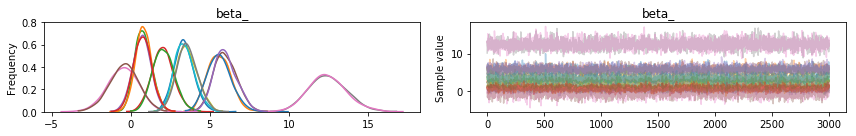

In [40]:
pm.traceplot(trace, varnames=['beta_'])

In [46]:
pm.summary(trace, varnames=['beta_']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta___0_0,3.39,0.63,0.01,2.18,4.66,1820.28,1.0
beta___0_1,2.07,0.68,0.02,0.73,3.39,1974.26,1.0
beta___0_2,-0.44,0.94,0.02,-2.31,1.37,2538.19,1.0
beta___1_0,5.60,0.74,0.01,4.22,7.04,2697.25,1.0
beta___1_1,0.74,0.57,0.01,-0.39,1.88,2336.80,1.0
beta___1_2,12.46,1.19,0.02,10.05,14.73,3207.43,1.0
beta___2_0,0.81,0.52,0.01,-0.17,1.87,2133.35,1.0
beta___2_1,5.99,0.72,0.01,4.61,7.38,2836.70,1.0
beta___2_2,3.57,0.66,0.01,2.31,4.89,2467.93,1.0


In [47]:
with model:
    ppc = pm.sample_ppc(trace)

100%|██████████████████████████████████████| 3000/3000 [01:07<00:00, 44.53it/s]


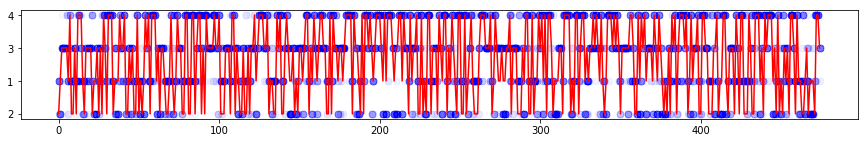

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))

"""for beta in zip(trace_df['beta__0'][::10], trace_df['beta__1'][::10]):
    samples = np.random.binomial(1, ss.expit(np.dot(np.asarray(X), np.asarray(beta))), size=df.obs_t.shape[0])
    plt.plot(samples, alpha=0.008, color='blue', lw=1)"""

plt.plot(ppc['likelihood'][::50].T, color='blue', alpha=0.01, ls='none', marker='o', markersize=7, label='$PPC$')

#samples = np.random.binomial(1, ss.expit(np.dot(np.asarray(X), trace_df.mean(axis=0))), size=df.obs_t.shape[0])
#plt.plot(samples, color='blue', label='$PPC_{mean}$')
    
plt.plot(df.Y.values.tolist(), color='red', label='$obs$')
pass